In [1]:
%%html
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
<style>
.rendered_html td {
    font-size: xx-large;
    text-align: left; !important
}
.rendered_html th {
    font-size: xx-large;
    text-align: left; !important
}
</style>

In [5]:
%%capture
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../statnlpbook/")
import ie
from wikidata.client import Client
import pandas as pd
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import re

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\a}{\alpha}
\newcommand{\b}{\beta}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

In [3]:
%load_ext tikzmagic

# Information Extraction

## Overview

* Knowledge bases
* Supervised relation extraction
* Pattern-based relation extraction
* Weak supervision
* Distance supervision

### Information extraction

* The amount of textual information is vast and still growing quickly
* Only some of information is relevant for each use case
* How can we automatically make sense of information?

### Subtasks of information extraction

* **Temporal** Information Extraction: recognise and/or normalise temporal expressions
  * e.g., "tomorrow morning at 8" -> "2016-11-26 08:00:00"

* **Event** Extraction: recognise events, typically consisting of entities and relations between them at a point in time and place

<img src="https://d3i71xaburhd42.cloudfront.net/b5aaf562669925ea617a06ad334d424d34115658/1-Figure1-1.png" width=60%/>

(from [Du & Cardie, 2020](https://aclanthology.org/2020.emnlp-main.49/))

* **Relation** Extraction: find instances of relations between entities

Scientific articles keep coming out. No one has time to read them all.

![covid_papers](../img/covid_papers.png)

(from https://scisight.apps.allenai.org/jnlpba/)

What if we could automatically explore associations in a large collection of articles?

<img src="../img/spike.png" width=50%/>

(from https://scisight.apps.allenai.org/jnlpba/)

Did you know these 10 companies own all the world's food brands?

![graph](../img/who-owns-what.jpg)

(from https://www.good.is/money/food-brands-owners)

It would be useful to automatically build a database of this form

<table style="font-size: x-large; border-style: solid;">
<tr><th style="text-align: left; border-style: solid;">Brand</th><th style="text-align: left; border-style: solid;">Parent</th></tr>
<tr><td style="text-align: left; border-style: solid;">KitKat</td><td style="text-align: left; border-style: solid;">Nestle</td></tr>
<tr><td style="text-align: left; border-style: solid;">Lipton</td><td style="text-align: left; border-style: solid;">Unilever</td></tr>
<tr><td style="text-align: left; border-style: solid;">...</td><td style="text-align: left; border-style: solid;">...</td></tr>
</table>

These are all instances of the "[owned by](https://www.wikidata.org/wiki/Property:P127)" relation.
Can also be expressed as:

```
owned_by(KitKat, Nestle)
owned_by(Lipton, Unilever)
...
```

The web contains a lot of **unstructured** textual evidence for this relation:

> <font color="blue">Dechra Pharmaceuticals</font>, which has just made its second acquisition, had previously purchased <font color="green">Genitrix</font>.

> <font color="blue">Trinity Mirror plc</font>, the largest British newspaper, purchased <font color="green">Local World</font>, its rival.

> <font color="blue">Kraft</font>, owner of <font color="green">Milka</font>, purchased <font color="green">Cadbury Dairy Milk</font> and is now gearing up for a roll-out of its new brand.


... and for many other relations.

```
born_in(Barack Obama, Hawaii)
educated_at(Albert Einstein, University of Zürich)
occupation(Steve Jobs, businessman)
spouse(Angela Merkel, Joachim Sauer)
...
```

## Relation extraction

1. **Named Entity Recognition (NER)** (see [sequence labeling](sequence_labeling_slides.ipynb)): text $\rightarrow$ (entity spans, entity types)
> <font color="green">Kraft</font>, owner of <font color="green">Milka</font>, purchased <font color="green">Cadbury Dairy Milk</font> and is now gearing up for a roll-out of its new brand.

2. **Coreference Resolution** (not covered in this course): text $\rightarrow$ clusters of spans referring to the same entities
> <font color="blue">Motor Vehicles International Corp.</font> announced a major management shake-up.... <font color="blue">MVI</font> said the chief executive officer has resigned.... <font color="blue">The Big 10 auto maker</font> is attempting to regain market share.... <font color="blue">It</font> will announce significant losses for the fourth quarter...

4. **Relation Classification (RC)**: (text, entity spans, entity types) $\rightarrow$ relation

```
Milka is owned by Kraft
Cadbury Dairy Milk is owned by Kraft
Kraft is not owned by Milka
...
```

### Knowledge bases

Store **structured** information in the form of relations between entities.

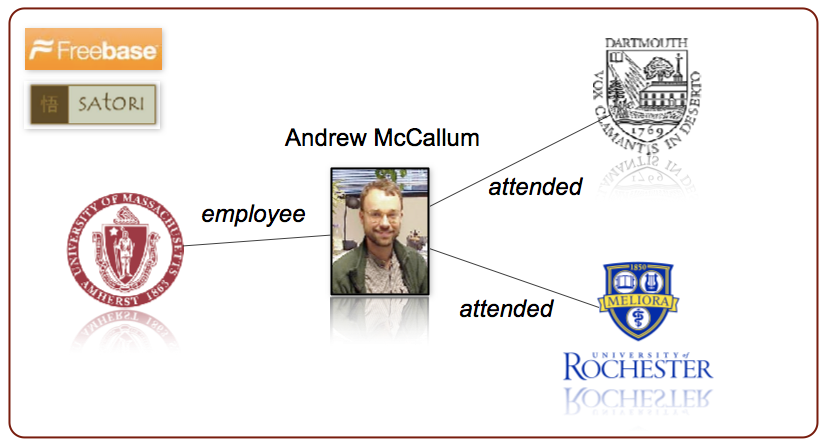


### Wikidata

[Manually created, free, multilingual knowledge base with 99,671,633 data items.](https://www.wikidata.org/)

* **Entities** have Q-codes, e.g.,
  * [Earth (Q2)](https://www.wikidata.org/wiki/Q2)
  * [Barack Obama (Q76)](https://www.wikidata.org/wiki/Q76)
  * [COVID-19 (Q84263196)](https://www.wikidata.org/wiki/Q84263196)
* **Properties** (relations) have P-codes, e.g.,
  * [instance of (P31)](https://www.wikidata.org/wiki/Property:P31)
  * [place of birth (P19)](https://www.wikidata.org/wiki/Property:P19)
  * [cause (Q2574811)](https://www.wikidata.org/wiki/Q2574811)
  
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/Wikidata-logo-en.svg/500px-Wikidata-logo-en.svg.png" width="600">

Can be represented as RDF* triples:

$$\langle\text{subject}, \text{relation}, \text{object}\rangle$$

*Resource Description Framework

### Relation extraction for automated knowledge base construction

Scaling up knowledge bases by structuring unstructured information.

Less accurate that manually constructed knowledge bases!

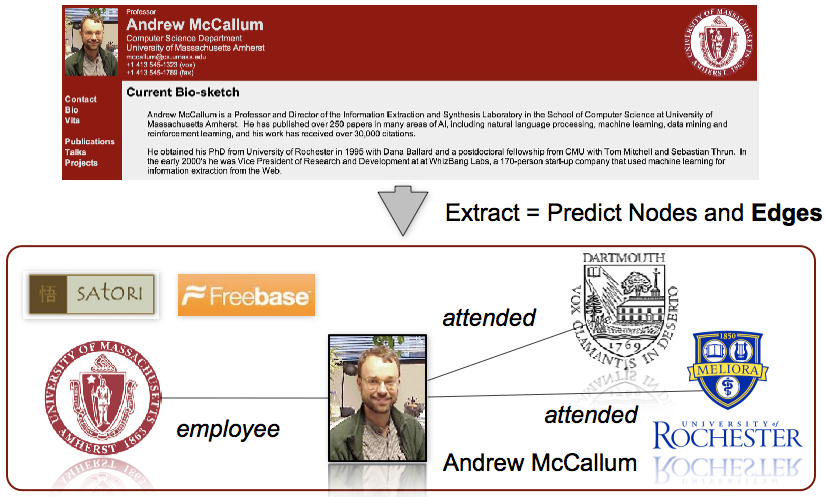

### Biomedical processes

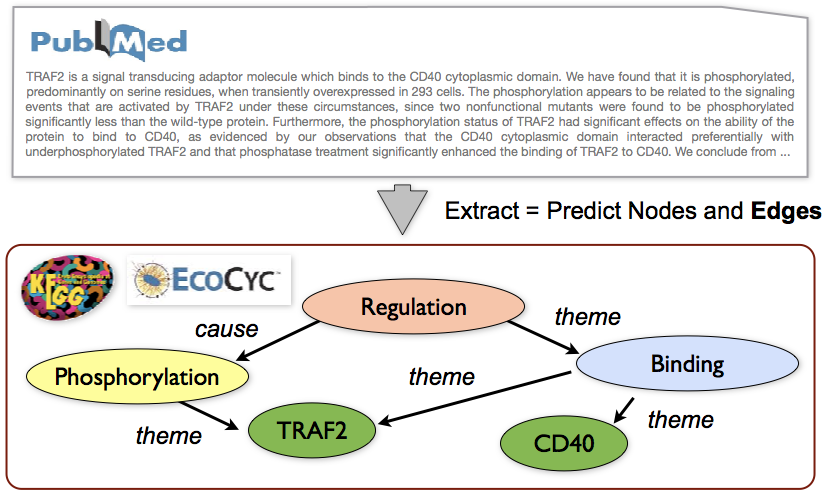

### Drug-gene interactions

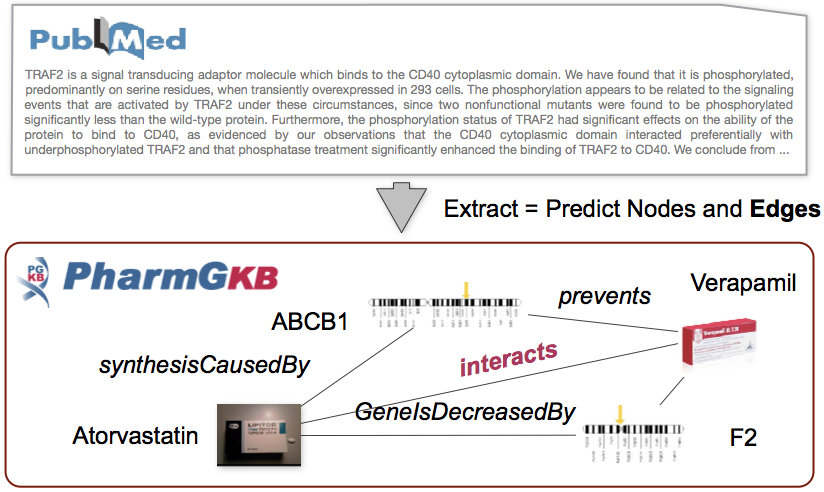

### Relation extraction examples

ReVerb ([Fader et al., 2011](https://www.aclweb.org/anthology/D11-1142.pdf)) demo:

* [who is owned by Nestle?](https://openie.allenai.org/search?arg1=&rel=owned+by&arg2=Nestle&corpora=)
* [whom did Google purchase?](https://openie.allenai.org/search?arg1=Google&rel=purchased&arg2=&corpora=)
* [who invented email?](https://openie.allenai.org/search?arg1=who&rel=invented&arg2=email&corpora=)

## How does it work?

### NER: text $\rightarrow$ (entity spans, entity types)

Sequence labeling with IOB encoding: label tokens as beginning (B), inside (I), or outside (O) a **named entity:**

| | | | | | |
|-|-|-|-|-|-|
| Barack | Obama | was |  born | in | Hawaii |
| B-per | I-per | O |  O | O | B-gpe |


### Decoding to entity spans

| |
|-|
| \[Barack Obama\]<sub>per</sub> was born in \[Hawaii\]<sub>gpe</sub> |


    per = Person
    gpe = Geopolitical Entity

### Relation classification: (text, entity spans, entity types) $\rightarrow$ relation


| Text | Entity 1    | type    |Entity 2    |type    | Relation   |
|---------|---------|-----------|-----------|-----------|-----------|
| Barack Obama was born in Hawaii | Barack Obama | `per` | Hawaii | `gpe` | born in  |

## Relation classification
* Input $\x\in\mathcal{X}=\mathcal{E}\times\mathcal{S}$: entity pairs $\in\mathcal{E}$ (possibly with types) and supporting texts $\in\mathcal{S}$
  * e.g., $\langle$Barack Obama, Hawaii$\rangle$, "Barack Obama was born in Hawaii"
* Output $y\in\mathcal{Y}$: set of relation labels
  * e.g., $\Ys=\{ \text{born_in}, \text{founder_of},\text{employee_at},\text{professor_at},\text{NOTA}\}$
  * ($\text{NOTA}$ = None of the Above, i.e., no relation)

* **Goal**: train model \\(s_{\params}(\x,y)\\) that assigns high *scores* to a correct label $\mathcal{y}$ for $\mathcal{\x}$, low scores otherwise 
* **Training**: learn parameters \\(\params\\) from training set of $(\mathcal{\x,y})$ pairs
* **Prediction** of labels for input instances $\mathcal{\x}$: solve maximisation problem $\argmax_y s_{\params}(\x,y)$.

## Labeled data

Popular relation extraction datasets:

* [TACRED](https://nlp.stanford.edu/projects/tacred/) (around 77% F1 [top performance](https://paperswithcode.com/sota/relation-extraction-on-tacred))
* [Re-TACRED](https://github.com/gstoica27/Re-TACRED)
* [TACREV](https://github.com/DFKI-NLP/tacrev)
* [DocRED](https://github.com/thunlp/DocRED)
* [FewRel](https://github.com/thunlp/fewrel)
* [SemEval 2010 Task 8](http://www.kozareva.com/downloads.html)
* [ACE 2005](https://catalog.ldc.upenn.edu/LDC2006T06)
* ...

### Example dataset

FewRel 2.0 ([Gao et al., 2019](https://aclanthology.org/D19-1649)): entities and relations linked to Wikidata.

The first step would normally be NER to detect pairs of entities $\mathcal{E}$. For simplicity, our data already contains those annotations.


In [4]:
client = Client()
data = ie.read_few_rel_data()
pcodes = list(data.keys())
pd.DataFrame([(pcode, str(client.get(pcode, load=True).label),
              instance['h'][0], instance['t'][0], " ".join(instance["tokens"]))
             for pcode in pcodes[:6] for instance in data[pcode][:2]],
            columns=["pcode", "label", "ent1", "ent2", "text"])

,pcode,label,ent1,ent2,text
0,P177,crosses,cape girardeau bridge,mississippi river,"In June 1987 , the Missouri Highway and Transp..."
1,P177,crosses,wilton bridge,river wye,Wilton Bridge was a major crossing of the ...
2,P364,original language of film or TV show,kaaviya thalaivi,tamil language,"Kaaviya Thalaivi ( தமிழ் : காவியத்தலைவி , ) is..."
3,P364,original language of film or TV show,daddy cool,hindi,"In 2009 , a Hindi remake of the film , entitle..."
4,P2094,competition class,yanqui díaz,heavyweight,"Gómez has had some success at heavyweight , ca..."
5,P2094,competition class,yuri arbachakov,flyweight,Sasakul turned pro in 1991 and captured the WB...
6,P361,part of,tales from the public domain,thirteenth season,"Following the release of "" The Simpsons "" thir..."
7,P361,part of,pāhoa,island of hawaii,Lava Tree State Monument is a public park loca...
8,P641,sport,bob gaudet,ice hockey,Bob Gaudet is an American ice hockey coach who...
9,P641,sport,fed cup,tennis,She played her best tennis in team competition...


## Challenges

* Diversity: `parent` can also be expressed as `mother/father` or even `child/son/daughter/...`
* Syntactic complexity:
> He married the American actress Cindy Robbins on November 27, 1965, in Beverly Hills, California, and was stepfather to her daughter, Kimberly Beck.
* Rare relations: `P1884` (hair color)
* Unseen relations: `deciphered`
* Unseen languages:
> Der Fluss Amazonas gab seinerseits dem Amazonasbecken sowie mehreren gleichnamigen Verwaltungseinheiten in Brasilien, Venezuela, Kolumbien

### Important note: extract, don't memorise

Our relation classifier should not simply memorise entity pairs and their relations.

It should learn to extract relations from new text.

$\to$ let's mask out the entities in the text!

In [5]:
def mask_entities(instance):
    tokens = list(instance["tokens"])
    for span, entlabel in sorted([(x, "<ENT1>") for x in instance["h"][2]] +
                                 [(x, "<ENT2>") for x in instance["t"][2]],
                                 reverse=True):
        tokens[span[0]] = entlabel
        for i in span[-1:0:-1]:
            del tokens[i]
    return {"tokens": tokens, "h": instance["h"], "t": instance["t"]}

masked = [(pcode, mask_entities(instance)) for pcode in pcodes for instance in data[pcode]]
random.shuffle(masked)
pd.DataFrame([(pcode, str(client.get(pcode, load=True).label),
              instance["h"][0], instance["t"][0], " ".join(instance["tokens"]))
             for pcode, instance in masked[:12]],
            columns=["pcode", "label", "ent1", "ent2", "text"])

,pcode,label,ent1,ent2,text
0,P177,crosses,market street bridge,schuylkill river,"The street continues westward , crossing over ..."
1,P25,mother,vibia aurelia sabina,faustina the younger,"<ENT1> ( 170-died before 217 ) , daughter and ..."
2,P413,position played on team / speciality,brad ziegler,reliever,The record stood for 101 years before being br...
3,P206,located in or next to body of water,passage island,lake superior,The <ENT1> Light Station is a lighthouse locat...
4,P410,military rank,charles john cecil grant,general,"<ENT2> Sir <ENT1> , ( 13 August 1877 – 9 Novem..."
5,P361,part of,parallel giant slalom final,2006 winter olympics,"At the <ENT2> , he faced his brother Philipp S..."
6,P26,spouse,mongkut,debsirindra,"Bhanurangsi Savangwongse , the Prince Bhanuban..."
7,P463,member of,nao,maximum the hormone,<ENT2> was formed in 1998 by vocalist Daisuke ...
8,P463,member of,georgia,guam organization for democracy and economic d...,<ENT2> is a regional organisation of four CIS ...
9,P410,military rank,"edward ""teddy"" mortlock donaldson",air commodore,Also within the churchyard is the grave of <EN...


Split to train, dev (validation) and test:

In [6]:
N = len(masked)
train_masked = masked[:int(.8*N)]
dev_masked = masked[int(.8*N):int(.9*N)]
test_masked = masked[int(.9*N):]
len(train_masked), len(dev_masked), len(test_masked)

(8960, 1120, 1120)

## Supervised relation classification
* Learn scoring model \\(s_{\params}(\x,y)\\) from training sentences $\mathcal{X}$ and their labels $\mathcal{Y}$
* At testing time, predict highest-scoring label for each testing instance: $$ \argmax_{\y\in\Ys} s_{\params}(\x,\y) $$

Let's implement a bag-of-words logistic regression classifier...

In [16]:
def unpack_instances(instances):
    return (
        [instance[0] for instance in instances],
        [" ".join(instance[1]["tokens"]) for instance in instances],
        [(instance[1]["h"][0], instance[1]["t"][0]) for instance in instances]
    )

def feat_transform(sents_train, sents_test):
    cv = CountVectorizer()
    cv.fit(sents_train)
    features_train = cv.transform(sents_train)
    features_test = cv.transform(sents_test)
    return features_train, features_test, cv

def model_train(feats_train, labels):
    model = LogisticRegression(penalty='l2', solver='liblinear')  # logistic regression model with l2 regularisation
    model.fit(feats_train, labels) # fit the model to the transformed training data
    return model

train_labels, train_masked_instances, train_entpairs = unpack_instances(train_masked)
dev_labels, dev_masked_instances, dev_entpairs = unpack_instances(dev_masked)
features_train, features_dev, cv = feat_transform(train_masked_instances, dev_masked_instances)
model = model_train(features_train, train_labels)

... and evaluate it on the dev set:

In [8]:
predicted = model.predict(features_dev)
accuracy = np.mean(predicted == dev_labels)
print(f"accuracy: {accuracy:.2}")

accuracy: 0.69


### Problem: too general

Sentences often express more than one relation

> He married the American actress Cindy Robbins on November 27, 1965, in Beverly Hills, California, and was stepfather to her daughter, Kimberly Beck.

Bag-of-words does not consider the targeted entity pair.

## Learning patterns for relation classification

Often only words between the entity spans are important, so let's only consider them.

In [10]:
def extract_patterns(texts):
    patterns = []
    for text in texts:
        text = re.sub(r".*?<ENT\d>", "", text, count=1)
        text = re.sub(r"<ENT\d>.*", "", text, count=1)
        patterns.append(text)
    return patterns

random.shuffle(train_masked_instances)
train_patterns = extract_patterns(train_masked_instances)
dev_patterns = extract_patterns(dev_masked_instances)
pd.DataFrame(zip(train_masked_instances[:10], train_patterns[:10]),
             columns=["masked text", "pattern"])

,masked text,pattern
0,<ENT2> propaganda persisted 30 years after Dac...,propaganda persisted 30 years after Dachau an...
1,"He debuted with the <ENT2> comedy "" <ENT1> "" (...","comedy """
2,"<ENT1> ( தமிழ் : காவியத்தலைவி , ) is a <ENT2> ...","( தமிழ் : காவியத்தலைவி , ) is a"
3,Nicolson was the elder son of authors Harold N...,and the brother of writer and politician
4,In 1661 he was elected MP for St Germans for t...,together with his brother
5,"Note : The Gandhi surname comes from <ENT2> , ...",", the husband of"
6,<ENT1> is a spiral galaxy in the constellation...,is a spiral galaxy in the constellation
7,Musician <ENT1> named his son <ENT2> after Ert...,named his son
8,The episode was the second ( following David O...,"installment """
9,<ENT1> ( English : Come Partner Come ) is a 19...,( English : Come Partner Come ) is a 1994


In [12]:
def feat_transform_patterns(sents_train, sents_test):
    cv = CountVectorizer(token_pattern=r".*")
    cv.fit(sents_train)
    features_train = cv.transform(sents_train)
    features_test = cv.transform(sents_test)
    return features_train, features_test, cv

pattern_features_train, pattern_features_dev, cv = feat_transform_patterns(train_patterns, dev_patterns)
pattern_model = model_train(pattern_features_train, train_labels)
pattern_predicted = pattern_model.predict(pattern_features_dev)
pattern_accuracy = np.mean(pattern_predicted == dev_labels)
print(f"accuracy: {pattern_accuracy:.2}")

accuracy: 0.037


In [14]:
train_patterns[:10]

[' propaganda persisted 30 years after Dachau and Auschwitz such as in the thinly disguised fascist Italian film " ',
 ' comedy " ',
 ' ( தமிழ் : காவியத்தலைவி , ) is a ',
 ' and the brother of writer and politician ',
 ' together with his brother ',
 ' , the husband of ',
 ' is a spiral galaxy in the constellation ',
 ' named his son ',
 ' installment " ',
 ' ( English : Come Partner Come ) is a 1994 ']

In [20]:
# use patterns to find more entity pairs
def search_for_entpairs_by_patterns(training_patterns, testing_patterns, testing_entpairs, testing_sentences):
    testing_extractions = []
    appearing_testing_patterns = []
    appearing_testing_entpairs = []
    for i, testing_pattern in enumerate(testing_patterns): # iterate over patterns
        if testing_pattern in training_patterns: # if there is an exact match of a pattern
            testing_extractions.append(testing_sentences[i]) # add the corresponding sentence
            appearing_testing_patterns.append(testing_pattern) # add the pattern
            appearing_testing_entpairs.append(testing_entpairs[i]) # add the entity pairs
    return testing_extractions, appearing_testing_patterns, appearing_testing_entpairs

# use entity pairs to find more patterns
def search_for_patterns_by_entpairs(training_entpairs, testing_patterns, testing_entpairs, testing_sentences):
    testing_extractions = []
    appearing_testing_patterns = []
    appearing_testing_entpairs = []
    for i, testing_entpair in enumerate(testing_entpairs): # iterate over entity pairs
        if testing_entpair in training_entpairs: # if there is an exact match of an entity pair
            testing_extractions.append(testing_sentences[i]) # add the corresponding sentence
            appearing_testing_entpairs.append(testing_entpair) # add the entity pair
            appearing_testing_patterns.append(testing_patterns[i]) # add the pattern
    return testing_extractions, appearing_testing_patterns, appearing_testing_entpairs

In [57]:
def bootstrapping_extraction(rel, seed_sents, seed_entpairs, test_sents, test_entpairs, num_iter=10):
    """
    Given a set of patterns and entity pairs for a relation, extracts more patterns and entity pairs iteratively
    Args:
        train_sents: training sentences with arguments masked
        train_entpairs: training entity pairs
        test_sents: testing sentences with arguments masked
        test_entpairs: testing entity pairs
    Returns:
        the testing sentences which the training patterns or any of the inferred patterns appeared in
    """
    extracts = []
    patterns = set(seed_sents)
    entpairs = list(seed_entpairs)

    # iteratively get more patterns and entity pairs
    for i in range(1, num_iter):
        accuracy = np.mean([instance[0] == rel for instance in extracts] or [0])
        print(f"Iteration {i}: {len(extracts)} extractions, {len(patterns)} patterns, {len(entpairs)} entpairs, accuracy: {accuracy:.2}")
        # get more patterns and entity pairs
        extracts_e, ext_dev_patterns_e, ext_dev_entpairs_e = search_for_patterns_by_entpairs(entpairs, dev_patterns, dev_entpairs, dev_masked)
        extracts_p, ext_dev_patterns_p, ext_dev_entpairs_p = search_for_entpairs_by_patterns(patterns, dev_patterns, dev_entpairs, dev_masked)
        # add them to the existing patterns and entity pairs for the next iteration
        patterns.update(ext_dev_patterns_p)
        patterns.update(ext_dev_patterns_e)
        entpairs.extend(ext_dev_entpairs_p)
        entpairs.extend(ext_dev_entpairs_e)
        extracts.extend(extracts_p)
        extracts.extend(extracts_e)

    return extracts, entpairs

In [87]:
onerel = "P25"
train_onerel = [instance for instance in train_masked if instance[0] == onerel]
train_labels, train_masked_instances, train_entpairs = unpack_instances(train_onerel)
train_patterns = extract_patterns(train_masked_instances)
extracts, entpairs = bootstrapping_extraction(onerel, train_patterns[:20], train_entpairs[:20], train_patterns + dev_patterns, train_entpairs + dev_entpairs, 10)

Iteration 1: 0 extractions, 20 patterns, 20 entpairs, accuracy: 0.0
Iteration 2: 1 extractions, 20 patterns, 21 entpairs, accuracy: 1.0
Iteration 3: 3 extractions, 20 patterns, 23 entpairs, accuracy: 1.0
Iteration 4: 5 extractions, 20 patterns, 25 entpairs, accuracy: 1.0
Iteration 5: 7 extractions, 20 patterns, 27 entpairs, accuracy: 1.0
Iteration 6: 9 extractions, 20 patterns, 29 entpairs, accuracy: 1.0
Iteration 7: 11 extractions, 20 patterns, 31 entpairs, accuracy: 1.0
Iteration 8: 13 extractions, 20 patterns, 33 entpairs, accuracy: 1.0
Iteration 9: 15 extractions, 20 patterns, 35 entpairs, accuracy: 1.0


### Another example dataset

Extracting `method used for task` relations from sentences in computer science publications.

Classify between this relation and `NOTA`.

Example publications:
* https://www.sciencedirect.com/science/article/pii/S1474034613000475
* https://www.sciencedirect.com/science/article/pii/S1474034613000773
* https://www.sciencedirect.com/science/article/pii/S1474034615000166

### Pattern-based extraction

In [12]:
training_patterns, training_entpairs = ie.readLabelledPatternData()
# Training patterns and entity pairs for relation `method used for task`
pd.DataFrame(zip(training_patterns[:3], training_entpairs[:3]), columns=["pattern", "entpair"])

,pattern,entpair
0,demonstrates XXXXX and clustering techniques f...,"[text mining, building domain ontology]"
1,demonstrates text mining and XXXXX for buildin...,"[clustering techniques, domain ontology]"
2,the XXXXX is able to enhance the XXXXX,"[ensemble classifier, detection of constructio..."


In [15]:
testing_patterns, testing_entpairs = ie.readPatternData()
# Testing patterns and entity pairs
list(zip(testing_patterns[0:3], testing_entpairs[:3]))

[('a method for estimation of XXXXX of XXXXX is presented',
  ['effective properties', 'porous materials']),
 ('accounting for XXXXX is essential for estimation of XXXXX',
  ['nonlinear effects', 'effective properties']),
 ('develops the heterogeneous XXXXX for fiber-reinforced XXXXX',
  ['feature model', 'object modeling'])]

In [13]:
def sentence_to_short_pattern(sent):
    """
    Returns the sequence between two arguments in a sentence, where the arguments have been masked
    Args:
        sent: the sentence
    Returns:
        the sequence between to arguments
    """
    sent_toks = sent.split(" ")
    indeces = [i for i, ltr in enumerate(sent_toks) if ltr == "XXXXX"]
    pattern = " ".join(sent_toks[indeces[0]+1:indeces[1]])
    return pattern

print(training_patterns[0])
sentence_to_short_pattern(training_patterns[0])

demonstrates XXXXX and clustering techniques for XXXXX


'and clustering techniques for'

In [16]:
def pattern_extraction(training_sentences, testing_sentences):
    """
    Given a set of patterns for a relation, searches for those patterns in other sentences
    Args:
        sent: training sentences with arguments masked, testing sentences with arguments masked
    Returns:
        the testing sentences which the training patterns appeared in
    """
    # convert training and testing sentences to short paths to obtain patterns
    training_patterns = set([sentence_to_short_pattern(train_sent) for train_sent in training_sentences])
    testing_patterns = [sentence_to_short_pattern(test_sent) for test_sent in testing_sentences]
    # look for match of training and testing patterns
    testing_extractions = []
    for i, testing_pattern in enumerate(testing_patterns):
        if testing_pattern in training_patterns: # look for exact matches of patterns
            testing_extractions.append(testing_sentences[i])
    return testing_extractions

pattern_extraction(training_patterns[:300], testing_patterns[:300])

['paper reviews applications of XXXXX in XXXXX',
 'a novel approach was developed to determine the XXXXX in XXXXX',
 'four different types of insoles were examined in terms of their effects on XXXXX in XXXXX',
 'the findings can aid in better understanding the insole design features that could improve XXXXX in XXXXX',
 'this new approach provides more degrees of freedom and XXXXX in XXXXX']

### Problem: too specific

Most patterns occur only in the particular sentence they were extracted from

### Possible solutions

* Use more general **linguistic** patterns such as `<subject> <verb> <object>` (e.g., `Dechra Pharmaceuticals purchased Genitrix`)
* Shortest dependency path between two entities (see [parsing slides](dependency_parsing_slides.ipynb))
* Representation learning with neural networks

<center>
    <img src="parsing_figures/dep4re.png" width="60%">
</center>

<img src="dl-applications-figures/WS_mapping.png" width="100%"/>

<div style="text-align: right;">
    Source: http://ai.stanford.edu/blog/weak-supervision/
</div>

## Weak supervision
* Supervised learning typically requires large amounts of hand-labelled training examples
* **Bootstrapping**: iterative pattern acquisition from unlabeled data
* One of the first algorithms: [DIPRE (Sergey Brin, 1999)](http://ilpubs.stanford.edu:8090/421/1/1999-65.pdf)
* Input: a set of entity pairs
* Repeat:
    * *use entity pairs* to find/generate (more) patterns
    * *apply patterns* to find entity pairs


In [17]:
# use patterns to find more entity pairs
def search_for_entpairs_by_patterns(training_patterns, testing_patterns, testing_entpairs, testing_sentences):
    testing_extractions = []
    appearing_testing_patterns = []
    appearing_testing_entpairs = []
    for i, testing_pattern in enumerate(testing_patterns): # iterate over patterns
        if testing_pattern in training_patterns: # if there is an exact match of a pattern
            testing_extractions.append(testing_sentences[i]) # add the corresponding sentence
            appearing_testing_patterns.append(testing_pattern) # add the pattern
            appearing_testing_entpairs.append(testing_entpairs[i]) # add the entity pairs
    return testing_extractions, appearing_testing_patterns, appearing_testing_entpairs

# use entity pairs to find more patterns
def search_for_patterns_by_entpairs(training_entpairs, testing_patterns, testing_entpairs, testing_sentences):
    testing_extractions = []
    appearing_testing_patterns = []
    appearing_testing_entpairs = []
    for i, testing_entpair in enumerate(testing_entpairs): # iterate over entity pairs
        if testing_entpair in training_entpairs: # if there is an exact match of an entity pair
            testing_extractions.append(testing_sentences[i]) # add the corresponding sentence
            appearing_testing_entpairs.append(testing_entpair) # add the entity pair
            appearing_testing_patterns.append(testing_patterns[i]) # add the pattern
    return testing_extractions, appearing_testing_patterns, appearing_testing_entpairs

In [18]:
def bootstrapping_extraction(train_sents, train_entpairs, test_sents, test_entpairs, num_iter=10):
    """
    Given a set of patterns and entity pairs for a relation, extracts more patterns and entity pairs iteratively
    Args:
        train_sents: training sentences with arguments masked
        train_entpairs: training entity pairs
        test_sents: testing sentences with arguments masked
        test_entpairs: testing entity pairs
    Returns:
        the testing sentences which the training patterns or any of the inferred patterns appeared in
    """
    # convert training and testing sentences to short paths to obtain patterns
    train_patterns = set([sentence_to_short_pattern(s) for s in train_sents])
    train_patterns.discard("in") # too general, remove this
    test_patterns = [sentence_to_short_pattern(s) for s in test_sents]
    test_extracts = []

    # iteratively get more patterns and entity pairs
    for i in range(1, num_iter):
        print("Number extractions at iteration", str(i), ":", str(len(test_extracts)))
        print("Number patterns at iteration", str(i), ":", str(len(train_patterns)))
        print("Number entpairs at iteration", str(i), ":", str(len(train_entpairs)))
        # get more patterns and entity pairs
        test_extracts_e, ext_test_patterns_e, ext_test_entpairs_e = search_for_patterns_by_entpairs(train_entpairs, test_patterns, test_entpairs, test_sents)
        test_extracts_p, ext_test_patterns_p, ext_test_entpairs_p = search_for_entpairs_by_patterns(train_patterns, test_patterns, test_entpairs, test_sents)
        # add them to the existing patterns and entity pairs for the next iteration
        train_patterns.update(ext_test_patterns_p)
        train_patterns.update(ext_test_patterns_e)
        train_entpairs.extend(ext_test_entpairs_p)
        train_entpairs.extend(ext_test_entpairs_e)
        test_extracts.extend(test_extracts_p)
        test_extracts.extend(test_extracts_e)

    return test_extracts, test_entpairs

In [19]:
test_extracts, test_entpairs = ie.bootstrappingExtraction(training_patterns[:20], training_entpairs[:20], testing_patterns, testing_entpairs, 10)

Number extractions at iteration 0 : 0
Number patterns at iteration 0 : 19
Number entpairs at iteration 0 : 20
Number extractions at iteration 1 : 78
Number patterns at iteration 1 : 19
Number entpairs at iteration 1 : 98
Number extractions at iteration 2 : 239
Number patterns at iteration 2 : 24
Number entpairs at iteration 2 : 259
Number extractions at iteration 3 : 405
Number patterns at iteration 3 : 24
Number entpairs at iteration 3 : 425
Number extractions at iteration 4 : 571
Number patterns at iteration 4 : 24
Number entpairs at iteration 4 : 591
Number extractions at iteration 5 : 737
Number patterns at iteration 5 : 24
Number entpairs at iteration 5 : 757
Number extractions at iteration 6 : 903
Number patterns at iteration 6 : 24
Number entpairs at iteration 6 : 923
Number extractions at iteration 7 : 1069
Number patterns at iteration 7 : 24
Number entpairs at iteration 7 : 1089
Number extractions at iteration 8 : 1235
Number patterns at iteration 8 : 24
Number entpairs at ite

With each iteration, the number of pattern, entity pairs and extractions increases.

However, they are less precise: **semantic drift**.


In [20]:
train_patterns = set(sentence_to_short_pattern(s) for s in training_patterns[:20])
test_patterns = set(sentence_to_short_pattern(s) for s in test_extracts)

# patterns that do not co-occur with first set of entity pairs
for p in test_patterns:
    if p not in train_patterns:
        print(p)

is introduced in
is firstly introduced in
is proposed to plan and execute task in
and finally to illustrate the applicability of the proposed method , a
is higher in


## Distant supervision

* We still have sentences $\mathcal{X}$ as an input, but they are unlabeled
* Obtain entity pairs $\mathcal{E}$ and relations $\mathcal{Y}$ from a **knowledge base**, e.g. [Wikidata](https://www.wikidata.org) or Freebase
* Automatically label all sentences that contain an entity pair with the associated relations
* Afterwards: supervised learning

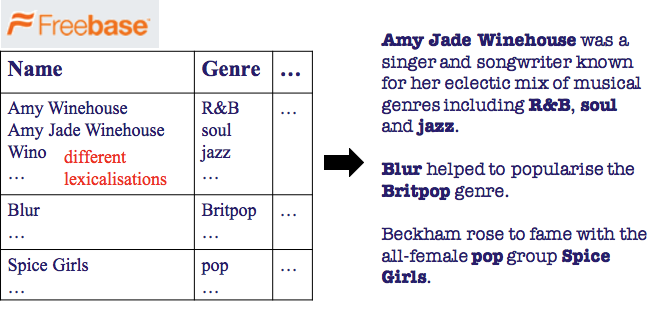

In [26]:
def feat_transform(sents_train, sents_test):
    cv = CountVectorizer()
    cv.fit(sents_train)
    features_train = cv.transform(sents_train)
    features_test = cv.transform(sents_test)
    return features_train, features_test, cv

from sklearn.linear_model import LogisticRegression

def model_train(feats_train, labels):
    model = LogisticRegression(penalty='l2', solver='liblinear')  # logistic regression model with l2 regularisation
    model.fit(feats_train, labels) # fit the model to the transformed training data
    return model

def predict(model, features_test):
    """Find the most compatible output class"""
    preds = model.predict(features_test) # this returns the predicted labels
    return preds

def supervised_extraction(train_sents, train_entpairs, train_labels, test_sents, test_entpairs):
    """
    Given pos/neg training instances, train a logistic regression model with simple BOW features and predict labels on unseen test instances
    Args:
        train_sents: training sentences with arguments masked
        train_entpairs: training entity pairs
        train_labels: labels of training instances
        test_sents: testing sentences with arguments masked
        test_entpairs: testing entity pairs
    Returns:
        predictions for the testing sentences
    """
    # extract short patterns from training and testing sentences
    train_patterns = [sentence_to_short_pattern(test_sent) for test_sent in train_sents]
    test_patterns = [sentence_to_short_pattern(test_sent) for test_sent in test_sents]
    features_train, features_test, cv = feat_transform(train_patterns, test_patterns) # extract features
    model = model_train(features_train, train_labels) # train model
    predictions = predict(model, features_test) # get predictions
    return predictions

In [27]:
def distantly_supervised_labelling(kb_entpairs, unlab_sents, unlab_entpairs):
    """
    Label instances using distant supervision assumption
    Args:
        kb_entpairs: entity pairs for a specific relation
        unlab_sents: unlabelled sentences with entity pairs anonymised
        unlab_entpairs: entity pairs which were anonymised in unlab_sents

    Returns: pos_train_sents, pos_train_enpairs, neg_train_sents, neg_train_entpairs

    """
    train_sents, train_entpairs, train_labels = [], [], []
    for i, unlab_entpair in enumerate(unlab_entpairs):
        # if the entity pair is a KB tuple, it is a positive example for that relation
        if unlab_entpair in kb_entpairs:  
            train_entpairs.append(unlab_entpair)
            train_sents.append(unlab_sents[i])
            train_labels.append("method used for task")
        else: # else, it is a negative example for that relation
            train_entpairs.append(unlab_entpair)
            train_sents.append(unlab_sents[i])
            train_labels.append("NONE")

    return train_sents, train_entpairs, train_labels

In [28]:
def distantly_supervised_extraction(kb_entpairs, unlab_sents, unlab_entpairs, test_sents, test_entpairs):
    # training_data <- Find training sentences with entity pairs
    train_sents, train_entpairs, train_labels = distantly_supervised_labelling(kb_entpairs, unlab_sents, unlab_entpairs)
    
    print("Distantly supervised labelling results in", train_labels.count("NONE"), 
          "negative training examples and", train_labels.count("method used for task"), "positive training examples")
    
    # training works the same as for supervised RE
    return supervised_extraction(train_sents, train_entpairs, train_labels, test_sents, test_entpairs)

In [29]:
kb_entpairs, unlab_sents, unlab_entpairs = ie.readDataForDistantSupervision()
#print(len(kb_entpairs), "'KB' entity pairs for relation `method used for task` :", kb_entpairs[0:5])
#print(len(unlab_entpairs), 'all entity pairs')
testing_preds = distantly_supervised_extraction(kb_entpairs, unlab_sents, unlab_entpairs, testing_patterns, testing_entpairs)
list(zip(testing_preds, testing_patterns, testing_entpairs))[:10]

Distantly supervised labelling results in 22 negative training examples and 22 positive training examples


[('NONE',
  'a method for estimation of XXXXX of XXXXX is presented',
  ['effective properties', 'porous materials']),
 ('method used for task',
  'accounting for XXXXX is essential for estimation of XXXXX',
  ['nonlinear effects', 'effective properties']),
 ('method used for task',
  'develops the heterogeneous XXXXX for fiber-reinforced XXXXX',
  ['feature model', 'object modeling']),
 ('NONE',
  'two formulations for the problem of optimum XXXXX of onshore XXXXX',
  ['layout design', 'wind farms']),
 ('method used for task',
  'boundary-value and initial-value XXXXX are solved using XXXXX and graph products',
  ['differential equations', 'finite difference method']),
 ('method used for task',
  'boundary-value and initial-value XXXXX are solved using finite difference method and XXXXX',
  ['differential equations', 'graph products']),
 ('method used for task',
  'boundary-value and initial-value differential equations are solved using XXXXX and XXXXX',
  ['finite difference method',

### Limitations of distant supervision

* Overlapping relations
* Ambiguous entities
* Mention vs. type annotations

For example, this relation holds:

`lives_in(Margrethe II of Denmark,  Amalienborg)`

but it would be wrong to attribute it to the sentence

> Margrethe was born 16 April 1940 at Amalienborg

## Summary so far

Various relation extraction techniques:
* Fully supervised
* Pattern-based
* Bootstrapping
* Distant supervision using knowledge bases

Features are often a mix of 
* Words, n-grams and patterns
* Syntax-based (relation path)
* Representation learning (word/sentence embedding)

## Background Material

* Jurafky, Dan and Martin, James H. (2016). [Speech and Language Processing, Chapter 17 (Information Extraction)](https://web.stanford.edu/~jurafsky/slp3/17.pdf)

## Further Reading

* Cardie, 1997. [Empirical Methods in Information Extraction](https://ojs.aaai.org//index.php/aimagazine/article/view/1322)
* Kumar (2017). [A Survey of Deep Learning Methods for Relation Extraction](https://arxiv.org/pdf/1705.03645.pdf)
* Ratner et al., 2018. [Weak Supervision: The New Programming Paradigm for Machine Learning](https://dawn.cs.stanford.edu/2017/07/16/weak-supervision/)
* Rosenman et al., 2020. [Exposing Shallow Heuristics of Relation Extraction Models with Challenge Data](https://arxiv.org/pdf/2010.03656.pdf)
* [Awesome relation extraction, curated list of resources on relation extraction](https://github.com/roomylee/awesome-relation-extraction)